## Load EEG data

In [2]:
import mne
from mne.preprocessing import ICA
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

session = 2
start_file = 37
end_file = 42

path = pathlib.Path('.')
eeg_file = list(path.glob('*.vhdr'))
assert len(eeg_file) == 1, "More than one .vhdr file found in this folder! There should only be one!"
eeg_file = str(eeg_file[0])

In [3]:
raw = mne.io.read_raw_brainvision(eeg_file, preload=True, verbose='WARNING')

In [4]:
# Make sure STIM channel not erroneously included in downstream processes
#raw.info['bads'].extend(['STI 014'])

# Remove all annotations (they cause issues otherwisew)
raw.set_annotations(None)

# Filter
raw.filter(1., 40., fir_design='firwin', n_jobs=-1)

# Set montage
#montage_path = r'C:\Users\AXM1390\Documents\RSVP\Misc'
montage_path = r'/home/alex/Documents/RSVP/Misc'
montage = mne.channels.read_montage(kind='CACS-64_NO_REF', path=montage_path)
raw.set_montage(montage)

<RawBrainVision  |  rsvp_greg_session2_files_37_42.eeg, n_channels x n_times : 64 x 871600 (871.6 sec), ~425.8 MB, data loaded>

In [5]:
# events = mne.find_events(raw)
events = np.load('events.npy')
raw, events = raw.resample(250, npad='auto', events=events, n_jobs=-1)
np.save('events_downsampled.npy', events)

In [6]:
raw.set_eeg_reference('average', projection=True)
raw.apply_proj() # Same as just above but with projection=False
# But keeping here for increased familiarity with the pipeline

SSP projectors applied...


<RawBrainVision  |  rsvp_greg_session2_files_37_42.eeg, n_channels x n_times : 64 x 217900 (871.6 sec), ~106.6 MB, data loaded>

### Scroll through data and see if there are any bad electrodes

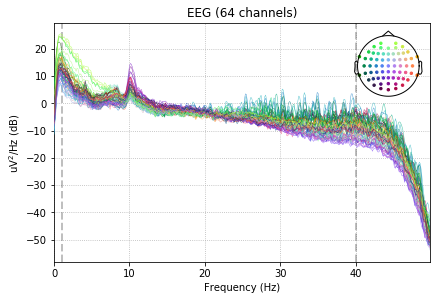

In [7]:
%matplotlib inline
raw.plot_psd(fmax=50);

In [ ]:
%matplotlib
raw.plot(title='Raw')

In [ ]:
raw.interpolate_bads()

In [ ]:
raw.get_data().shape

In [8]:
# ICA 

method = 'fastica'
n_components = raw.info['nchan'] - 1  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time
ica = ICA(n_components=n_components, method=method)
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')
ica.fit(raw, picks=picks_eeg, decim=None, reject=None)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 63 components
Fitting ICA took 11.4s.


<ICA  |  raw data decomposition, fit (fastica): 217900 samples, 63 components, channels used: "eeg">

In [ ]:
#ica = mne.preprocessing.read_ica('ICA_solution_session0_0_to_11')

### Plot / select ICA components for removal

In [12]:
%matplotlib qt
# ica.plot_components();
ica.plot_sources(raw);

ICA Notes: 

In [ ]:
print(ica.exclude)

In [13]:
ica.save(f'ICA_solution_session{session}_{start_file}_to_{end_file}')

Writing ICA solution to ICA_solution_session2_37_to_42...


<ipython-input-13-4205a11ba796>:1: RuntimeWarning: This filename (ICA_solution_session2_37_to_42) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(f'ICA_solution_session{session}_{start_file}_to_{end_file}')


<ICA  |  raw data decomposition, fit (fastica): 217900 samples, 63 components, channels used: "eeg", 22 sources marked for exclusion>

In [ ]:
# raw.plot(events=events, title="RAW");

In [18]:
ica_excluded = ica.apply(raw.copy())
#ica_excluded.plot(events=events, title="Removed ICs");

Transforming to ICA space (63 components)
Zeroing out 22 ICA components


In [21]:
raw_icadone = ica_excluded

pos2code = {"NOUN":500, "VERB":501, "ADJ":502, "DET":503, "PRON":504,
            "ADP":505, "ADV":506, "AUX":507, "CCONJ":508, "INTJ":509,
            "NUM":510, "PART":511, "PROPN":512, "PUNCT":513, "SCONJ":514, "X":516}

In [22]:
epochs = mne.Epochs(raw_icadone, events, event_id=pos2code, baseline=(-0.05, 0), tmin=-0.1, tmax=0.6,
                    proj=True, preload=True, reject=None, reject_by_annotation=None)

2762 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 2762 events and 176 original time points ...
0 bad epochs dropped


## Saving
* The raw data can be derived again, so maybe don't need to save a raw fif file of anything but the epochs

In [23]:
epochs.save(f'rsvp_greg_session{session}_files{start_file}-{end_file}_600ms-epo.fif')

<ipython-input-23-b4afa90895b6>:1: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  epochs.save(f'rsvp_greg_session{session}_files{start_file}-{end_file}_600ms-epo.fif')


In [24]:
raw_icadone.save(f'rsvp_session{session}_files{start_file}-{end_file}_icadone.fif')

<ipython-input-24-7ba21634bfb3>:1: RuntimeWarning: This filename (rsvp_session2_files37-42_icadone.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_icadone.save(f'rsvp_session{session}_files{start_file}-{end_file}_icadone.fif')


In [ ]:
# Quick look at some ERPs

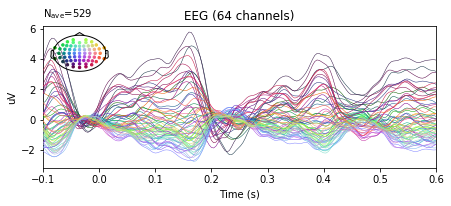

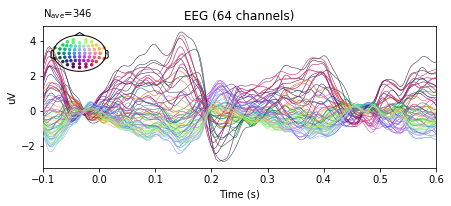

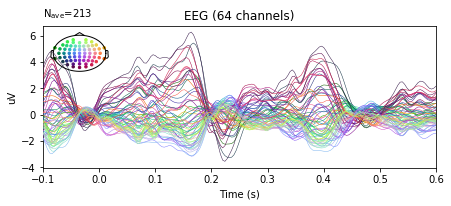

In [25]:
%matplotlib inline

epochs["NOUN"].average().plot(spatial_colors=True);
epochs["VERB"].average().plot(spatial_colors=True);
epochs["ADJ"].average().plot(spatial_colors=True);